<a href="https://colab.research.google.com/github/AleksanderSokolov/algorithm/blob/master/TreeProgect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 4. Деревья решений

### Реализация дерева решений

In [0]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [0]:
import pandas as pd

In [270]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
!pip install kaggle
api_token = {"username":"sokolovaleksander","key":"23f64fa7ccc4dc7e849121b0ea598aae"}
import json
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive')
# copy kaggle token file from google drive to colab
!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/Colab Notebooks/kaggle/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!pip install kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
kaggle.json


In [271]:
!kaggle competitions download -c choose-tutors

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
submission_example.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
df = pd.read_csv('train.csv')

In [0]:
dfTest = pd.read_csv('test.csv')

In [274]:
df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [0]:
arrChoose = df['choose'].values

In [0]:
arr = df.drop(columns=['choose','Id'], axis=1).values

In [277]:
df.columns.values

array(['Id', 'age', 'years_of_experience', 'lesson_price',
       'qualification', 'physics', 'chemistry', 'biology', 'english',
       'geography', 'history', 'mean_exam_points', 'choose'], dtype=object)

In [0]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(arr, 
                                                                                     arrChoose, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [0]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [0]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [0]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [0]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [0]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [0]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 2

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [0]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality <= 0.0001:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Формирование случайного леса


Реализуем генерацию  N  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле ??

In [0]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [0]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [0]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
 
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [0]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [0]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [0]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [0]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
#print_tree(my_tree)

In [0]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [0]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [0]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [296]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.98571428571428

In [297]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

85.8

Для визуализации сократим данные


In [0]:
arr = df.drop(columns=['Id', 'age',
       'qualification', 'physics', 'chemistry', 'biology', 'english',
       'geography', 'history', 'mean_exam_points', 'choose'], axis=1).values

In [0]:
# Построим дерево по обучающей выборке с меньшим количеством признаков для графиков

train_data_plt, test_data_plt, train_labels_plt, test_labels_plt = model_selection.train_test_split(arr, 
                                                                                     arrChoose, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

my_tree_plt = build_tree(train_data_plt, train_labels_plt)

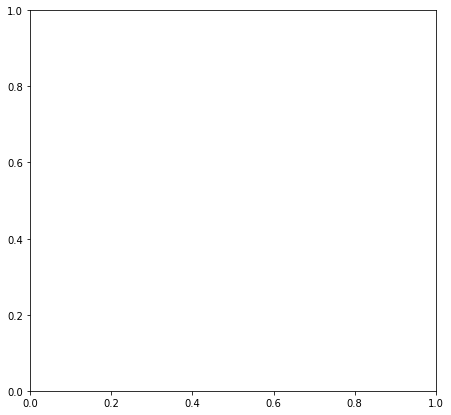

In [300]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data_plt)

In [0]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

Text(0.5, 1.0, 'Test accuracy=85.80')

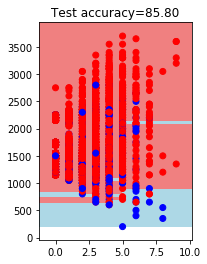

In [302]:

mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_plt)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels_plt, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data_plt[:, 0], test_data_plt[:, 1], c = test_labels_plt, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [0]:
from graphviz import Digraph

Нарисовать дерево

In [0]:
def visualize_tree(tree):
    def add_nodes_edges(tree, dot=None):
        # Create Digraph object
        if dot is None:
            dot = Digraph()
            dot.node(name=str(tree), label=str(tree.index))

        if isinstance(tree, Leaf):
          if tree.prediction==0:
            dot.node(name=str(tree) ,label=str(tree.prediction), color='green')
          else:
            dot.node(name=str(tree) ,label=str(tree.prediction), color='red',shape = 'box' )  
          return dot    

        # Add nodes
        if tree.false_branch:
          if isinstance(tree.false_branch, Leaf):
            dot.node(name=str(tree.false_branch) ,label=str(tree.false_branch.prediction))
            dot.edge(str(tree), str(tree.false_branch))
            dot = add_nodes_edges(tree.false_branch, dot=dot)
          else:
            dot.node(name=str(tree.false_branch) ,label=str(tree.false_branch.index))
            dot.edge(str(tree), str(tree.false_branch))
            dot = add_nodes_edges(tree.false_branch, dot=dot)
            
        if tree.true_branch:
          if isinstance(tree.true_branch, Leaf):
            dot.node(name=str(tree.true_branch) ,label=str(tree.true_branch.prediction))
            dot.edge(str(tree), str(tree.true_branch))
            dot = add_nodes_edges(tree.true_branch, dot=dot)
          else:
            dot.node(name=str(tree.true_branch) ,label=str(tree.true_branch.index))
            dot.edge(str(tree), str(tree.true_branch))
            dot = add_nodes_edges(tree.true_branch, dot=dot)

        return dot
    
    # Add nodes recursively and create a list of edges
    dot = add_nodes_edges(tree)

    # Visualize the graph
    display(dot)
    
    return dot

In [0]:
#dot = visualize_tree(my_tree)

roc_auc

In [306]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = np.array(test_labels)
y_scores = np.array(answers)
roc_auc_score(y_true, y_scores)


0.6243576728657994

Построим лес

In [307]:
%%time
n_trees = 800
my_forest = random_forest(train_data, train_labels, n_trees)

CPU times: user 55min 16s, sys: 12.2 s, total: 55min 28s
Wall time: 55min 31s


In [0]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest, train_data)

In [0]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest, test_data)

In [310]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 800 деревьев на обучающей выборке: 94.471


In [311]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 800 деревьев на тестовой выборке: 89.500


In [312]:
roc_auc_score(test_labels, test_answers)

0.6012024991889148

In [0]:
# И получим ответы для всей выборки
all_answers = tree_vote(my_forest, dfTest.drop(columns=['Id'], axis=1).values)

In [0]:
dfTest['choose']=all_answers

In [315]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dfTest.loc[:, ['Id', 'choose']].to_csv('submission.csv',index=False, encoding='utf-8')

In [317]:
!kaggle competitions submit -c choose-tutors -f submission.csv -m "n_trees =800, 2"



100% 97.7k/97.7k [00:01<00:00, 50.7kB/s]
Successfully submitted to Choose tutors